In [1]:
from reservoir import ESN
from misc import *
import numpy as np
import time
import SYCLOP_env as syc
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
class  Syclop_Teacher:
    def __init__(self):
        self.hp = HP()
        self.hp.dt = 0.1
        self.hp.omega0 = 2*np.pi / 10.
        self.hp.A = 5.0 #target amplitude of oscillations. Target max speed is hence omega*A
        self.hp.noi = 0.01
        self.speed_lim = self.hp.omega0 * self.hp.A
        self.vel = 0
    def step(self,dvs_strip):        
        dvs_strip = dvs_strip + self.hp.noi*np.random.normal(size=np.shape(dvs_strip))
        I = dvs_strip**2.0
        I = I/(np.sum(I)+1e-10)
        centre = np.sum(I*np.array(range(len(dvs_strip))))- len(dvs_strip)/2.0 
        print('centre:',centre)
        self.vel += self.hp.dt*self.hp.omega0*centre 
        self.vel = self.vel if np.abs(self.vel)<self.speed_lim else self.speed_lim*np.sign(self.vel)


In [3]:
class Edge_Mover(syc.Scene):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.reset()
#         self.wave = [super().maxx//2]
        self.wave = [self.maxx//2]
    def reset(self):
        self.step = 0 
    def load_wave(self,wave):
        self.wave = wave
    def update(self): 
        self.step += 1
        self.edge_image_x(self.wave[self.step if self.step < len(self.wave) else -1])
#     def load_pwl(self,pwl):
#         self.pwl = pwl
#     def load_step(self,pwl):
#         self.pwl = pwl

In [4]:
def local_observer(sensor,agent):
    return np.concatenate([sensor.dvs_view[5,:].reshape([-1]),agent.qdot])
A = 1
A0 = 0
t_vec = np.array(list(range(1000)))
f_vec = np.sin(2*np.pi*t_vec/30.0)

In [5]:
    hp=HP()
    hp.max_episode = 3000
    hp.steps_per_episode = 4000
    hp.steps_between_learnings = 1000
    sceney,scenex  = 28,300

    recorder = Recorder(n=6)
    vertical_edge_mat = np.zeros([sceney,scenex])
    vertical_edge_mat[:,int(vertical_edge_mat.shape[1]/2):] = 1.0

    scene = Edge_Mover(image_matrix=vertical_edge_mat)
    sensor = syc.Sensor()
    agent = syc.Agent(max_q = [scene.maxx-sensor.hp.winx,scene.maxy-sensor.hp.winy])
    reward = syc.Rewards()
    esn = ESN(n_inputs = 52)

    esn.hp.g=1.5
    esn.reset()
    esn.wfb = esn.wfb*0.1

    hp.scene = scene.hp
    hp.sensor = sensor.hp
    hp.agent = agent.hp
    hp.reward = reward.hp


In [6]:
def pwl_to_wave(pwl):
    w_prev=[0,pwl[0][1]]
    wave =[]
    for w_this in pwl:
        wave += list(np.linspace(w_prev[1],w_this[1],max(w_this[0]-w_prev[0]+1,0)))[1:]
        w_prev = w_this
    return wave

In [7]:
len(pwl_to_wave([[0,1],[10,3],[20,-4],[38,4],[40,10]]))

40

In [8]:
pwl_to_wave([[0,1],[10,3],[20,-4],[38,4],[40,10]])

[1.2,
 1.3999999999999999,
 1.6000000000000001,
 1.8,
 2.0,
 2.2000000000000002,
 2.4000000000000004,
 2.6000000000000001,
 2.7999999999999998,
 3.0,
 2.2999999999999998,
 1.6000000000000001,
 0.90000000000000036,
 0.20000000000000018,
 -0.5,
 -1.1999999999999993,
 -1.8999999999999995,
 -2.5999999999999996,
 -3.2999999999999998,
 -4.0,
 -3.5555555555555554,
 -3.1111111111111112,
 -2.666666666666667,
 -2.2222222222222223,
 -1.7777777777777777,
 -1.3333333333333335,
 -0.88888888888888928,
 -0.44444444444444464,
 0.0,
 0.44444444444444464,
 0.8888888888888884,
 1.333333333333333,
 1.7777777777777777,
 2.2222222222222214,
 2.6666666666666661,
 3.1111111111111107,
 3.5555555555555554,
 4.0,
 7.0,
 10.0]

In [9]:
scene.load_wave([150]*500+[160]*500+[145]*500+[160]*500+[155]*500+[140]*500+[170]*500+[160]*500+[145]*500+[145]*500+[160]*500+[155]*500)

In [10]:
wave1=pwl_to_wave([[0,150],[400,160],[900,145],[1350,190],[2000,100],[2400,110],[2600,80],[2800,110],[3300,115],[4000,160]])

In [11]:
scene.load_wave(wave1)

In [12]:
plt.figure()
plt.plot(wave1)

<IPython.core.display.Javascript object>

In [13]:
scene.reset()

In [14]:
teacher = Syclop_Teacher()

In [15]:
def run_period(this_recorder,teacher=None,scenario=None):
    observation = local_observer(sensor,agent)
    for step in range(hp.steps_per_episode):
        esn.step(uin = observation.reshape([-1,1]))
        scene.update()
        if training_on:
            teacher.step(observation.reshape([-1])[:-2])
            esn.FORCE_step(teacher.vel)
        agent.qdot[0] = A0+A*esn.z
#         agent.qdot[0] = A0+A*teacher.vel
        agent.act(None)
        sensor.update(scene,agent)
#         print( teacher.vel, agent.q)
        reward.update_rewards(sensor = sensor, agent = agent)
        observation_  = local_observer(sensor,agent) #todo: generalize
        this_recorder.record([agent.q_ana[0],agent.q[0],agent.qdot[0],reward.rewards[0],reward.rewards[1],reward.reward])
        observation = observation_
        step += 1

In [16]:
training_on = True
agent.q_ana = np.array([scenex/2.+3.,sceney/2.+3.])
agent.act(None)
run_period(recorder,teacher=teacher)

centre: 2.10754236862
centre: 3.32121667194
centre: -0.330754440909
centre: 1.90037456281
centre: -0.158169263782
centre: -5.48495616095
centre: -1.21527993228
centre: 0.473527689971
centre: -2.37561569285
centre: 0.692354350447
centre: -1.53678202471
centre: 1.6337748339
centre: 3.31679891339
centre: 0.751018559819
centre: -4.89305480924
centre: -1.53919961462
centre: -0.896328358376
centre: -3.68001515484
centre: 0.0900605158676
centre: -1.5708507758
centre: 5.07420866408
centre: -5.83192509928
centre: -7.89781172222
centre: -0.383028792175
centre: -24.9426382464
centre: -24.4034160458
centre: -22.9626523382
centre: -20.4372294285
centre: -16.9659927295
centre: -13.4918752886
centre: -10.487237959
centre: -7.46124363287
centre: -4.48202997677
centre: -1.01597092911
centre: 2.50410877498
centre: 5.46753495483
centre: 8.49493403379
centre: 10.9777473337
centre: 13.4657299431
centre: 16.4459795978
centre: 18.4635009977
centre: 2.8252011118
centre: 18.4374255357
centre: 16.4280109758
cen

In [17]:
sceney/2.+3.,scenex/2.+3.

(17.0, 153.0)

In [18]:
agent.q_ana = np.array([sceney/2.+3.,scenex/2.+3.])
print(agent.q_ana,agent.q)
agent.act(None)
print(agent.q_ana,agent.q)

[  17.  153.] [119   2]
[ 17.03382284   2.        ] [17  2]


In [19]:
agent.max_q

[250, 2]

<IPython.core.display.Javascript object>


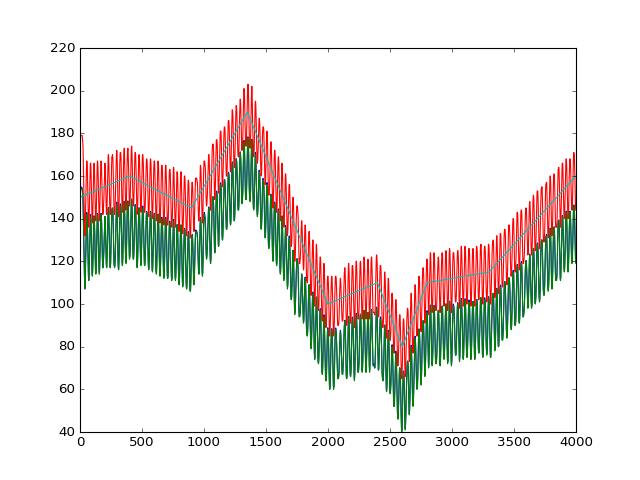

In [20]:
plt.figure()
plt.plot(recorder.records[0])
plt.plot(recorder.records[1])
plt.plot(np.array(recorder.records[1])+hp.winx//2)
plt.plot(scene.wave)

In [21]:
training_on = False

In [22]:
agent.q_ana = [scenex//2+sensor.hp.winx//2,2]
print(agent.q, agent.q_ana)
agent.act(None)
print(agent.q, agent.q_ana)

[17  2] [175, 2]
[175   2] [ 175.03382284    2.        ]


In [23]:
scenex//2+sensor.hp.winx//2

175

In [24]:
new_recorder = Recorder(n=6)

In [25]:
scene.reset()

In [29]:
scene.load_wave(pwl_to_wave([[0,280],[4000,150]]))
scene.load_wave(pwl_to_wave([[0,150],[4000,280]]))
scene.reset()
run_period(new_recorder)


<IPython.core.display.Javascript object>


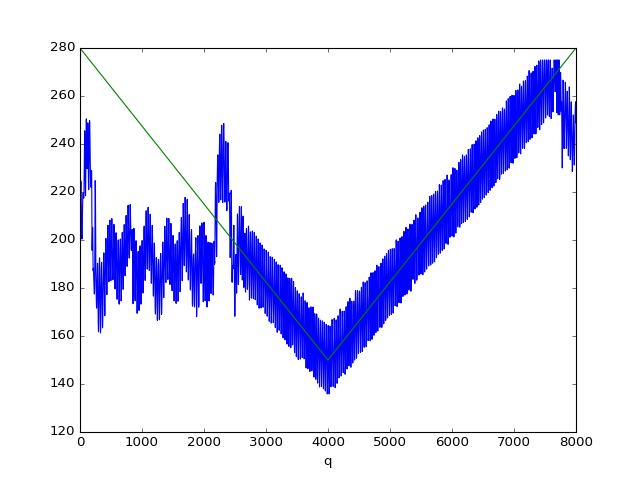

In [31]:
plt.figure()

plt.plot(np.array(new_recorder.records[0])+agent.hp.winx/2)
plt.plot(pwl_to_wave([[0,280],[4000,150]])+pwl_to_wave([[0,150],[4000,280]]))
plt.xlabel('q')


# plt.legend([str(uu) for uu in contrast_levels])

<IPython.core.display.Javascript object>


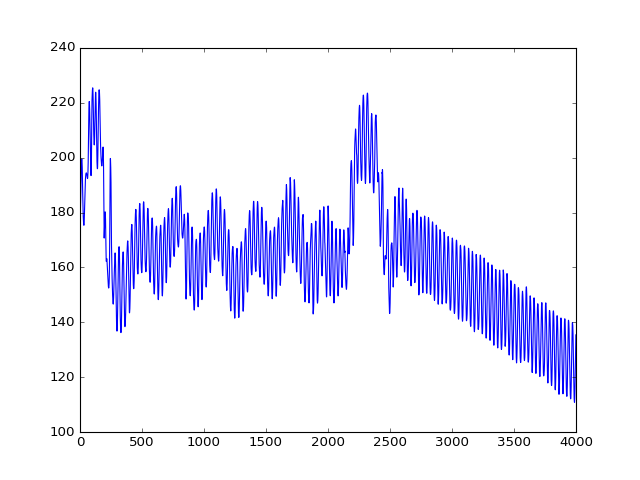

NameError: name 'contrast_levels' is not defined

In [28]:
plt.figure()
plt.plot(new_recorder.records[0])
plt.legend([str(uu) for uu in contrast_levels])
plt.xlabel('time')
plt.ylabel('q')
plt.title('contrast')
#plt.plot(scene.wave)

In [ ]:
plt.figure()
plt.plot(scene.wave)

In [ ]:
agent.q_ana = np.array([sceney/2.+3.,scenex/2.+3.])
agent.act(None)

In [ ]:
new_recorder2 = Recorder(n=6)
edge_placement = [150,160,170,180]    
for ii, ee in enumerate(edge_placement):    
    vertical_edge_mat = np.zeros([sceney,scenex])
    vertical_edge_mat[:,ee:] = 1
    scene = syc.Scene(image_matrix=vertical_edge_mat)
    run_period(new_recorder2)
    print(ii)

In [ ]:
plt.figure()
for chunk in range(5):
    plt.plot(new_recorder2.records[0][chunk*1000:(chunk+1)*1000],new_recorder2.records[2][chunk*1000:(chunk+1)*1000])
plt.xlabel('q')
plt.ylabel('dq/dt')
plt.title('location')
plt.legend([str(uu) for uu in edge_placement])

In [ ]:
plt.figure()
for chunk in range(5):
    plt.plot(list(range(chunk*1000,(chunk+1)*1000)),new_recorder2.records[0][chunk*1000:(chunk+1)*1000])
plt.legend([str(uu) for uu in edge_placement])
plt.title('location')
plt.xlabel('time')
plt.ylabel('q')

In [ ]:
plt.figure()
for chunk in range(5):
    plt.plot(new_recorder2.records[2][chunk*1000:(chunk+1)*1000],new_recorder2.records[3][chunk*1000:(chunk+1)*1000],'.')
plt.ylabel('intensity')
plt.xlabel('dq/dt')
plt.title('location')
plt.legend([str(uu) for uu in edge_placement])

In [ ]:
qdot_vec = np.linspace(-1.1,1.1,23)

In [ ]:
qdot_vec

In [ ]:
means=[]
for qdotmin,qdotmax in zip(qdot_vec[:-1],qdot_vec[1:]):
    qq= np.logical_and(np.array(new_recorder2.records[2])<=qdotmax,  np.array(new_recorder2.records[2])>=qdotmin)
    means.append(np.mean(np.array(new_recorder2.records[3])[qq]))

In [ ]:
len(np.array([12,12,12]))/2

In [ ]:
plt.plot(qdot_vec[:-1]+0.05,means,linewidth=3)

In [ ]:
plt.figure()
plt.plot(recorder.records[0])

In [ ]:
plt.figure()
plt.plot(recorder.records[0],recorder.records[3],'.')

In [ ]:
scenex/2.+3.

In [ ]:
vertical_edge_mat

In [ ]:
    def bubu(dvs_strip):        
        dvs_strip = dvs_strip + np.random.normal(size=np.shape(dvs_strip))
        I = dvs_strip**2.0
        I = I/(np.sum(I)+1e-10)
        centre = np.sum(I*np.array(range(len(dvs_strip))))- len(dvs_strip)/2.0 
        return centre

In [ ]:
bubu([0,0,0,0,1,0,0,0])